# Jupyter Notebook for Illumination Flat Field

Required packages are: 
`numpy, astropy, photutils, jwst (pipeline)`

In [29]:
import os
import sys
import copy
import time
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D, NDData
from astropy.stats import gaussian_sigma_to_fwhm, sigma_clipped_stats
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS

from photutils import EPSFBuilder, find_peaks
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, RectangularAperture, RectangularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, SExtractorBackground, ModeEstimatorBackground, MedianBackground
from photutils.background import MADStdBackgroundRMS
from photutils.centroids import centroid_2dg
from photutils.utils import calc_total_error

%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from jwst import datamodels

In [30]:
#This example will assume we have two NIRISS images: 

f1 = 'jw01086001001_01101_00021_nis_cal.fits'
f2 = 'jw01086001001_01101_00045_nis_cal.fits'

In [31]:
im1 = datamodels.open(f1)
data1 = copy.deepcopy(im1.data)
photmjsr1 = getattr(im1.meta.photometry,'conversion_megajanskys')
data_cps1 = data1/photmjsr1
print(photmjsr1)

0.37078890204429626


In [32]:
im2 = datamodels.open(f2)
data2 = copy.deepcopy(im2.data)
photmjsr2 = getattr(im2.meta.photometry,'conversion_megajanskys')
data_cps2 = data2/photmjsr2
print(photmjsr2)

0.37078890204429626


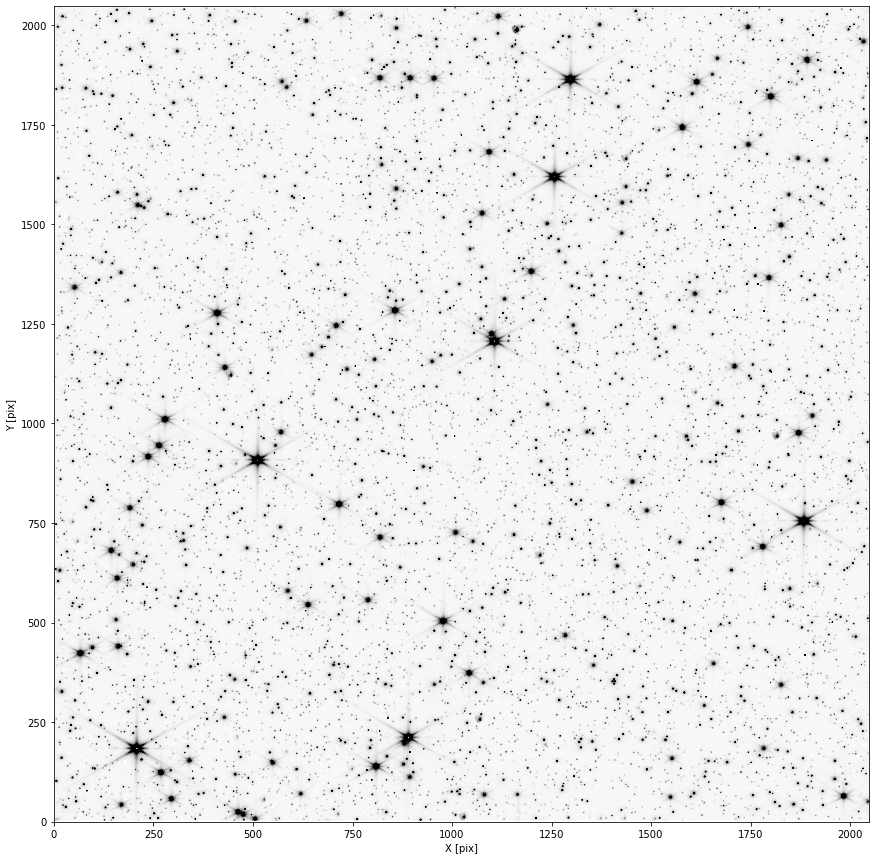

In [33]:
# Display one of the two images

plt.figure(figsize=(15,15))
ax = plt.subplot()
norm = simple_norm(data_cps1, 'sqrt', percent=99.)
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
ax.imshow(data_cps1, norm=norm, cmap="Greys", origin='lower')

In [34]:
# Estimate background and identify stars to be used for building PSF via photutils tasks 
# The parameters below work generally well for NIRISS images

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
std1 = bkgrms(data_cps1)
bkg1 = mmm_bkg(data_cps1)
psf_stars1 = IRAFStarFinder(threshold=100*std1 + bkg1, fwhm=2.0, minsep_fwhm=7, 
                            roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
sources1 = psf_stars1(data_cps1)
print(std1,bkg1,len(sources1))

0.4934196078045637 0.9796515693911809 4446


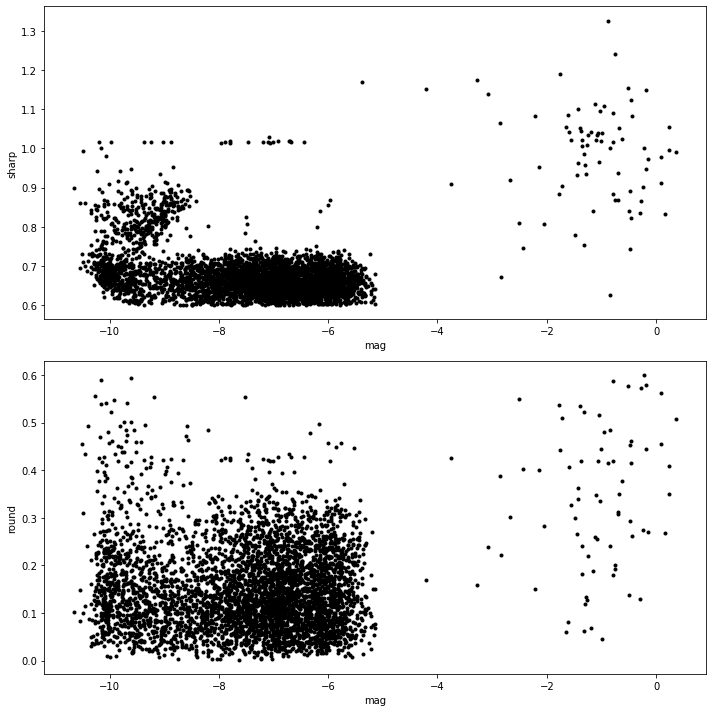

In [35]:
# Inspect plots like below to make sure we're picking up most of the stars while avoiding junks

fig, axs = plt.subplots(2,1, figsize=(10,10))
axs[0].plot(sources1['mag'], sources1['sharpness'], 'ko', markersize=3)
axs[0].set_xlabel('mag')
axs[0].set_ylabel('sharp')
axs[1].plot(sources1['mag'], sources1['roundness'], 'ko', markersize=3)
axs[1].set_xlabel('mag')
axs[1].set_ylabel('round')
fig.tight_layout()
plt.show()

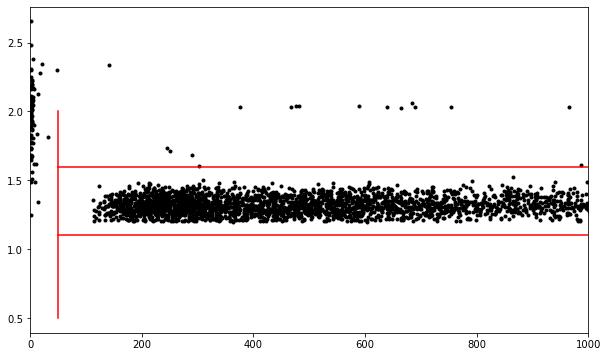

In [36]:
# Another plot we might want to inspect is the fwhm vs flux

plt.figure(figsize=(10,6))
plt.plot(sources1['flux'],sources1['fwhm'],'ko', markersize=3)
plt.xlim(0,1000)
plt.plot([50,50],[0.5,2],color='red')
plt.plot([50,1000],[1.6,1.6],color='red')
plt.plot([50,1000],[1.1,1.1],color='red')
plt.show()

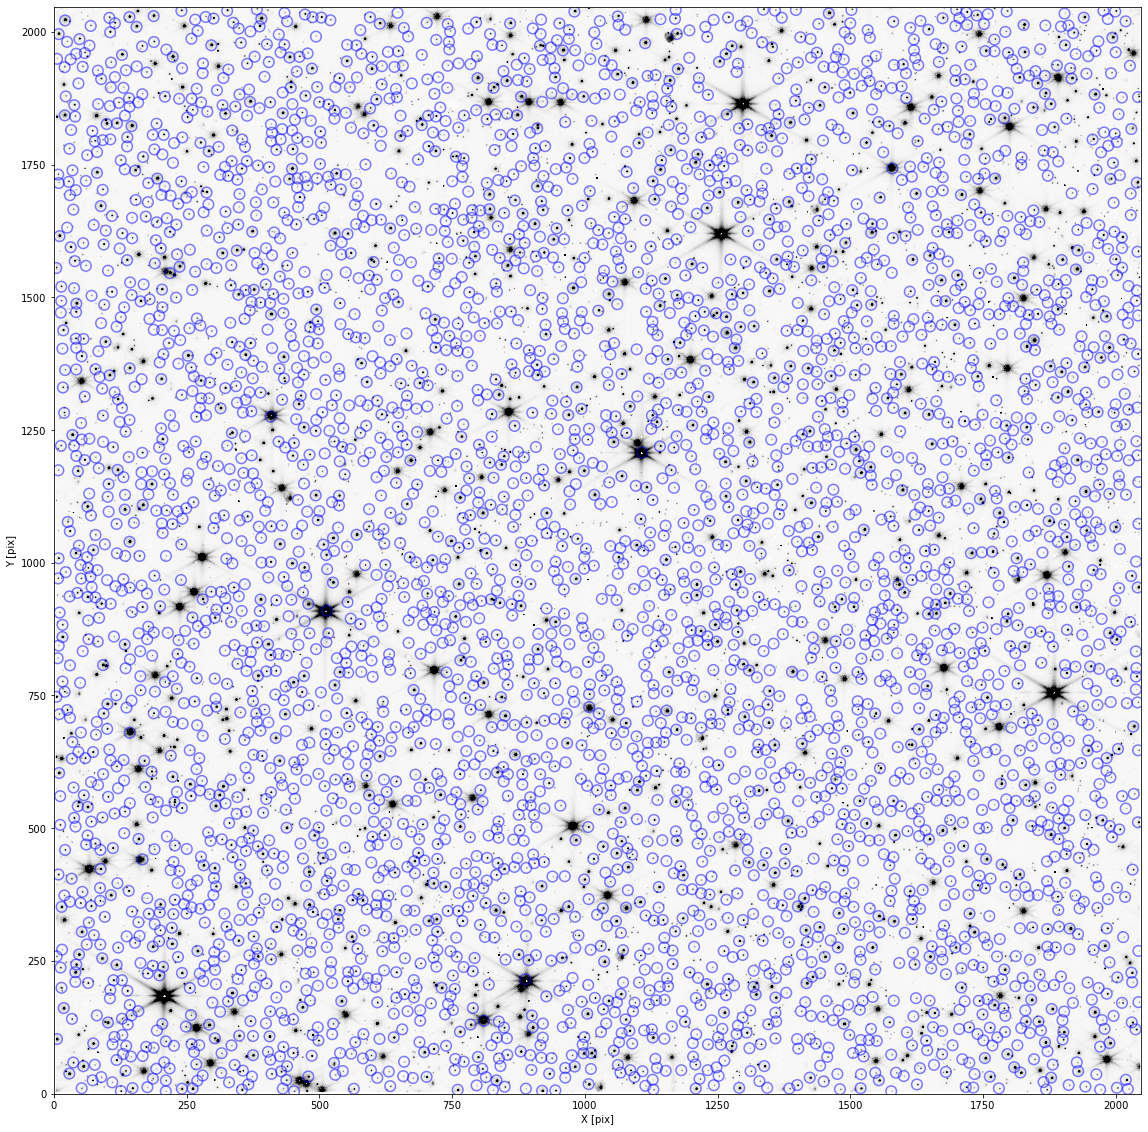

In [37]:
# From the plot above, good sources have 1.1<FWHM<1.6 pix and flux>50
# Apply these filters (or masks) and overplot the detected sources on the image to make sure we're dealing with actual stars

mask = (sources1['fwhm']>1.1) & (sources1['fwhm']<1.6) & (sources1['flux']>20) 
sources_masked1 = sources1[mask]
positions1 = np.transpose((sources_masked1['xcentroid'], sources_masked1['ycentroid']))
apertures1 = CircularAperture(positions1, r=10)
plt.figure(figsize=(20,20))
ax = plt.subplot()
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
ax.imshow(data_cps1, norm=norm, cmap='Greys', origin='lower')
apertures1.plot(color='blue', lw=1.5, alpha=0.5)

In [38]:
# Okay, now we'll do the same for the second image without inspection.

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
std2 = bkgrms(data_cps2)
bkg2 = mmm_bkg(data_cps2)
psf_stars2 = IRAFStarFinder(threshold=100*std2 + bkg2, fwhm=2.0, minsep_fwhm=7, 
                            roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
sources2 = psf_stars2(data_cps2)
mask = (sources2['fwhm']>1.1) & (sources2['fwhm']<1.6) & (sources2['flux']>20) 
sources_masked2 = sources2[mask]


In [39]:
# Now perform aperture photometry on the stars
# First image
positions1 = np.transpose((sources_masked1['xcentroid'], sources_masked1['ycentroid']))
apertures1 = CircularAperture(positions1, r=3)
annulus_apertures1 = CircularAnnulus(positions1, r_in=6, r_out=10)
annulus_masks1 = annulus_apertures1.to_mask(method='center')
bkg_median = []
for mask in annulus_masks1:
  annulus_data = mask.multiply(data_cps1)
  annulus_data_1d = annulus_data[mask.data > 0]
  _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
  bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot1 = aperture_photometry(data_cps1, apertures1)
phot1['annulus_median'] = bkg_median
phot1['aper_bkg'] = bkg_median * apertures1.area
phot1['aper_sum_bkgsub'] = phot1['aperture_sum'] - phot1['aper_bkg']

In [40]:
# Second image
positions2 = np.transpose((sources_masked2['xcentroid'], sources_masked2['ycentroid']))
apertures2 = CircularAperture(positions2, r=3)
annulus_apertures2 = CircularAnnulus(positions2, r_in=6, r_out=10)
annulus_masks2 = annulus_apertures2.to_mask(method='center')
bkg_median = []
for mask in annulus_masks2:
  annulus_data = mask.multiply(data_cps2)
  annulus_data_1d = annulus_data[mask.data > 0]
  _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
  bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot2 = aperture_photometry(data_cps2, apertures2)
phot2['annulus_median'] = bkg_median
phot2['aper_bkg'] = bkg_median * apertures2.area
phot2['aper_sum_bkgsub'] = phot2['aperture_sum'] - phot2['aper_bkg']

In [41]:
# From Kevin Volk's email sent to me on Mar 26, 2021

#  Assumed A0V spectral template: Bohlin Sirius (2020)
#  Filter              Count Rate       Mean F_nu       Pivot              Photometric Values
#                                                     Wavelength                    
#                        ADU/sec           Jy          Microns    (MJy/ster)/(ADU/s)      Jy/(ADU/s)
#NIRISS F090W          2.804222e+11   8.371777e+03     0.902458      1.673899e-10       2.985419e-08
#NIRISS F115W          2.347116e+11   6.508594e+03     1.149542      1.554807e-10       2.773018e-08
#NIRISS F140M          7.340864e+10   4.757672e+03     1.404035      3.633885e-10       6.481080e-08
#NIRISS F150W          1.391529e+11   4.346497e+03     1.493457      1.751341e-10       3.123539e-08
#NIRISS F158M          6.487924e+10   3.939552e+03     1.582011      3.404590e-10       6.072129e-08
#NIRISS F200W          9.570604e+10   2.755850e+03     1.992961      1.614508e-10       2.879494e-08
#NIRISS F277W          5.573678e+10   1.575708e+03     2.764281      1.585104e-10       2.827052e-08
#NIRISS F356W          3.667514e+10   9.791757e+02     3.593004      1.496969e-10       2.669862e-08
#NIRISS F380M          6.607656e+09   8.561057e+02     3.825227      7.264468e-10       1.295627e-07
#NIRISS F430M          4.290003e+09   6.923615e+02     4.283827      9.048971e-10       1.613895e-07
#NIRISS F444W          2.242869e+10   6.615412e+02     4.427699      1.653776e-10       2.949531e-08
#NIRISS F480M          3.839979e+09   5.582376e+02     4.815243      8.151061e-10       1.453752e-07
#Guider 1              1.379334e+12   4.478894e+03     2.501078      1.684581e-11       3.247142e-09
#Guider 2              1.604525e+12   4.291017e+03     2.591652      1.386584e-11       2.674322e-09


In [42]:
# Rename tables and add magnitude columns
t1 = phot1
t2 = phot2

### Magnitude zero points were set using the table above.
### 2.5LOG10(1.391529e+11 ADU/sec) = 27.8587

t1['mag'] = -2.5*np.log10(t1['aper_sum_bkgsub'])+27.8587-1.401
t1['mag_err'] = 1.0857*np.sqrt(t1['aper_sum_bkgsub'])/t1['aper_sum_bkgsub']

t2['mag'] = -2.5*np.log10(t2['aper_sum_bkgsub'])+27.8587-1.401
t2['mag_err'] = 1.0857*np.sqrt(t2['aper_sum_bkgsub'])/t2['aper_sum_bkgsub']

/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [43]:
#
# Convert the detected positions into sky coordinates (RA, Dec) in degrees
#

fn1 = fits.open(f1)
w1 = WCS(fn1[1].header)
c1 = w1.pixel_to_world(t1['xcenter'], t1['ycenter'])
t1['ra_deg'], t1['dec_deg'] = c1.ra.value, c1.dec.value

fn2 = fits.open(f2)
w2 = WCS(fn2[1].header)
c2 = w2.pixel_to_world(t2['xcenter'], t2['ycenter'])
t2['ra_deg'], t2['dec_deg'] = c2.ra.value, c2.dec.value

In [44]:
# At this stage, let's save the resulting photometry table to files so I don't have to 
# repeat all the steps above in case something goes wrong with this session

t1.write('jw01086001001_01101_00021_nis_cal_photutils.fits', format='fits', overwrite=True)
t2.write('jw01086001001_01101_00045_nis_cal_photutils.fits', format='fits', overwrite=True)

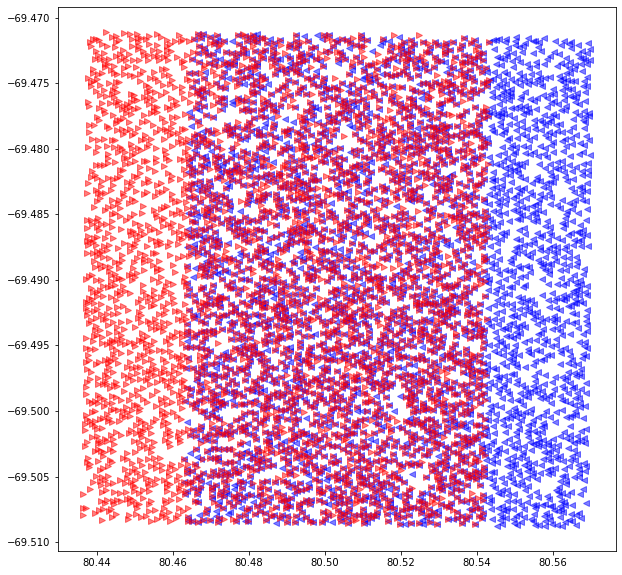

In [45]:
# Let's take a look at how the sky coordinates look like for each catalog
plt.figure(figsize=(10,10))
plt.plot(t1['ra_deg'], t1['dec_deg'],'b<',alpha=0.5)
plt.plot(t2['ra_deg'], t2['dec_deg'],'r>',alpha=0.5)
plt.show()

In [46]:
# Now let's do the coordinate-based crossmatching
# For this, we use the simple match_coordinates_sky method from astropy.coordinates

idx, d2d, d3d = match_coordinates_sky(c2, c1)

### Note!!!: idx is the index of c1

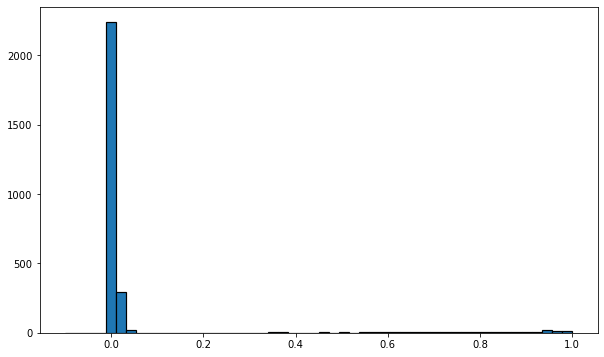

In [47]:
# Inspect the distance between matched sources to find out how to select good sources.

plt.figure(figsize=(10,6))
plt.hist(d2d.arcsecond, histtype='bar', edgecolor='black', linewidth=1.2, bins=50, range=(-0.1,1))
plt.show()

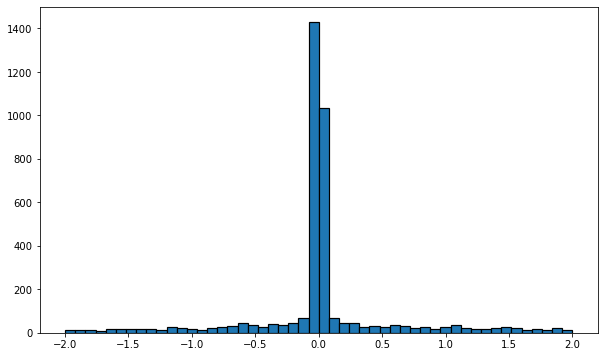

In [48]:
# Also inspect difference in magnitudes.

dmag = t2['mag'] - t1['mag'][idx]
plt.figure(figsize=(10,6))
plt.hist(dmag, histtype='bar', edgecolor='black', linewidth=1.2, bins=50, range=(-2,2))
plt.show()

In [49]:
t1.colnames

['id',
 'xcenter',
 'ycenter',
 'aperture_sum',
 'annulus_median',
 'aper_bkg',
 'aper_sum_bkgsub',
 'mag',
 'mag_err',
 'ra_deg',
 'dec_deg']

In [50]:
# First, create a crossmatched catalog that includes ALL sources. 
# We'll do the filtering later.

t = Table()
t['ra_cat1']  = t1['ra_deg'][idx]
t['dec_cat1'] = t1['dec_deg'][idx]
t['x_cat1']   = t1['xcenter'][idx]
t['y_cat1']   = t1['ycenter'][idx]
t['mag_cat1']     = t1['mag'][idx]
t['magerr_cat1']  = t1['mag_err'][idx]
t['ra_cat2']  = t2['ra_deg']
t['dec_cat2'] = t2['dec_deg']
t['x_cat2']   = t2['xcenter']
t['y_cat2']   = t2['ycenter']
t['mag_cat2']     = t2['mag']
t['magerr_cat2']  = t2['mag_err']
t['sep2d_arcsec']   = d2d.arcsecond

t.colnames

['ra_cat1',
 'dec_cat1',
 'x_cat1',
 'y_cat1',
 'mag_cat1',
 'magerr_cat1',
 'ra_cat2',
 'dec_cat2',
 'x_cat2',
 'y_cat2',
 'mag_cat2',
 'magerr_cat2',
 'sep2d_arcsec']

In [51]:
# Now filter out the bad matches and write the crossmatched catalog to a FITS table

mask = (t['sep2d_arcsec'] < 0.1)
t_filtered = t[mask]
t_filtered.write('crossmatched.fits', format='fits', overwrite=True)

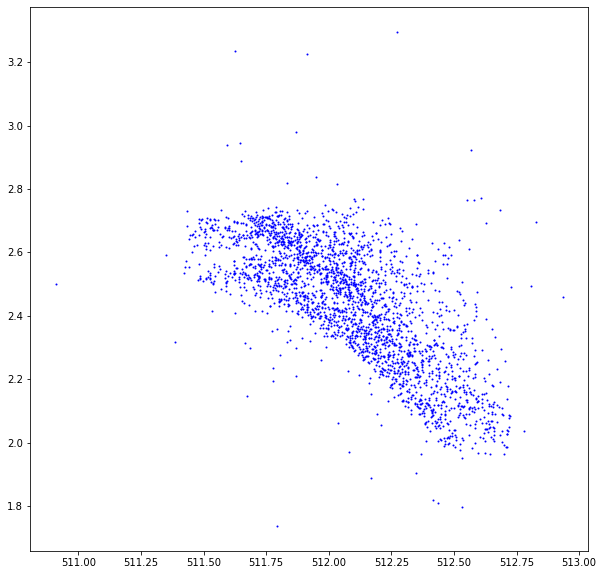

In [52]:
delx = t_filtered['x_cat1'] - t_filtered['x_cat2']
dely = t_filtered['y_cat1'] - t_filtered['y_cat2']
plt.figure(figsize=(10,10))
plt.plot(delx, dely,'bo', markersize=1.0)
plt.show()

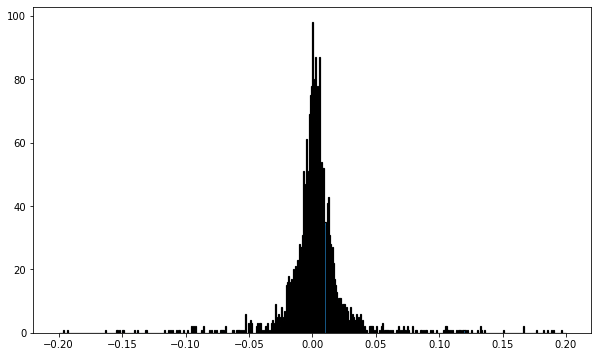

In [53]:
dmag = t_filtered['mag_cat1'] - t_filtered['mag_cat2']
plt.figure(figsize=(10,6))
plt.hist(dmag, histtype='bar', edgecolor='black', linewidth=1.2, bins=500, range=[-0.2,0.2])
plt.show()

In [54]:
from scipy.stats import norm
from astropy.stats import sigma_clip
filtered_dmag = sigma_clip(dmag, sigma=3, maxiters=10, masked=False)
filtered_dmag


-0.02961318018025949
-0.02830419541558271
0.013006429472511627
0.025630343392961663
0.002290947909855845
-0.0004502741021781276
0.00540259565978829
-0.0015029301760378644
0.017016262189276432
0.005837037464242911
-0.006376413675841519


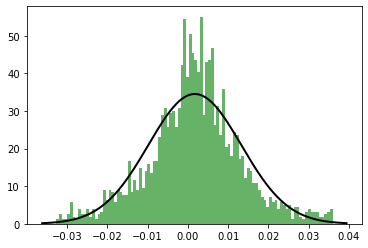

In [55]:
mu, std = norm.fit(filtered_dmag)
plt.hist(filtered_dmag, bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [56]:
print(mu,std)

0.0017381235063333898 0.011556322130936268
